Aperiodic tilings are awesome. This is a recreation of the Penrose tilings as explained at https://preshing.com/20110831/penrose-tiling-explained/.

We'll be working with triangles, so first let's define a triangle and how to draw them, plus some utility functions for drawing stuff:

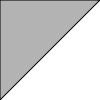

In [7]:
from collections import namedtuple
from io import BytesIO
import cairo
import IPython.display

class Tri(namedtuple('Tri', ('a', 'b', 'c', 'colour'))):
    def trace(self, ctx):
        ctx.move_to(self.a.real, self.a.imag)
        ctx.line_to(self.b.real, self.b.imag)
        ctx.line_to(self.c.real, self.c.imag)
        ctx.close_path()
    
    def draw(self, ctx):
        self.trace(ctx)
        ctx.set_source_rgb(*(self.rgba[0:-1]))
        ctx.stroke()
        self.trace(ctx)
        ctx.set_source_rgba(*self.rgba)
        ctx.fill()    
        
    @property
    def rgba(self):
        return 0, 0, 0, 0.3 + 0.3*self.colour

def bbox(points):
    points = list(points)
    topleft  = min(p.real for p in points) + 1j*min(p.imag for p in points)
    botright = max(p.real for p in points) + 1j*max(p.imag for p in points)
    return topleft, botright

def tripoints(tris):
    for tri in tris:
        yield tri.a
        yield tri.b
        yield tri.c

def set_bbox(ctx, points, target_size=100):
    topleft, botright = bbox(points)
    longer_side = max(botright.imag - topleft.imag, botright.real - topleft.real)
    scale  = target_size / longer_side
    ctx.translate(-topleft.real*scale, -topleft.imag*scale)
    ctx.scale(target_size, target_size)
        
def show_tris(tris, size=100):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, size, size) as surface: 
        ctx = cairo.Context(surface)
        set_bbox(ctx, tripoints(tris), size)
        ctx.set_line_width(0.01)
        ctx.set_line_join(cairo.LINE_JOIN_ROUND)
        for tri in tris: tri.draw(ctx)
    return IPython.display.SVG(data=svgio.getvalue())

show_tris([Tri(0+0j, 1+0j, 0+1j, 0)])

A Penrose tiling is generated by subdividing isosceles triangles -- see the explanation linked above.

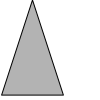

In [8]:
import cmath as m

triangles = [Tri(0+0j, m.rect(1, m.pi/2 + m.pi/10), m.rect(1, m.pi/2 - m.pi/10), 0)]

show_tris(triangles)